# Experiment 1: Stream Scaling

Please run each cell, and follow the instructions at the end in the "Analyze Results" section.

In [5]:
from __future__ import annotations

import importlib
import math
import os
import pathlib

import plotly.express as px
import plotly.graph_objects as go
import polars
import theme
from plotly.subplots import make_subplots
from proxystore.utils.data import bytes_to_readable

importlib.reload(theme)

<module 'theme' from '/analysis/notebooks/theme.py'>

In [2]:
def load_data(directory):
    run_data = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results.csv')
    )
    return run_data

In [3]:
def generate_figure(data, layout=None, skip_sizes=()):
    data = data.with_columns(
        (
            polars.col('end_tasks_done_timestamp')
            - polars.col('start_submit_tasks_timestamp')
        ).alias('runtime'),
    ).sort('workers')
    data = data.with_columns(
        (polars.col('task_count') / polars.col('runtime')).alias(
            'tasks_per_second',
        ),
    )

    data_sizes = (
        data.select(polars.col('data_size_bytes')).to_series().to_list()
    )
    data_sizes = [s for s in data_sizes if s not in skip_sizes]
    data_sizes = sorted(set(data_sizes))
    data_sizes_readable = [bytes_to_readable(size) for size in data_sizes]

    titles = [f'Stream Item Size: {size}' for size in data_sizes_readable]
    fig = make_subplots(
        rows=1,
        cols=len(data_sizes),
        horizontal_spacing=0.025,
        subplot_titles=titles,
        shared_yaxes=True,
    )

    colors = px.colors.qualitative.Bold[0:2][::-1]
    markers = ('circle', 'diamond')

    for i, data_size in enumerate(data_sizes):
        coldata = data.filter(polars.col('data_size_bytes') == data_size)

        workers = coldata.select(polars.col('workers')).to_series().to_list()
        workers = sorted(set(workers))

        for j, use_proxies in enumerate((False, True)):
            subdata = coldata.filter(polars.col('use_proxies') == use_proxies)
            scatter_data = go.Scatter(
                x=subdata['workers'],
                y=subdata['tasks_per_second'],
                name='ProxyStream' if use_proxies else 'Redis Pub/Sub',
                line=dict(color=colors[j]),
                mode='lines+markers',
                marker=dict(symbol=markers[j], size=10),
                showlegend=i == 0,
            )
            fig.add_trace(scatter_data, row=1, col=i + 1)
            fig.update_xaxes(title_text='Workers', row=1, col=i + 1)

        baseline_workers = min(workers) - 1
        task_sleep = coldata.row(0, named=True)['task_sleep']
        baseline_task_per_second = baseline_workers / task_sleep
        ideal_task_per_second = [
            baseline_task_per_second * (w - 1) for w in workers
        ]

        scatter_ideal = go.Scatter(
            x=workers,
            y=ideal_task_per_second,
            name='Ideal',
            line=dict(color='black', dash='dash'),
            mode='lines',
            showlegend=i == 0,
        )
        fig.add_trace(scatter_ideal, row=1, col=i + 1)

    workers = data.select(polars.col('workers')).to_series().to_list()
    workers = sorted(set(workers))

    fig.update_annotations(font_size=12)
    xaxis = {
        'xaxis' if i == 0 else f'xaxis{i+1}': dict(
            type='log',
            tickmode='array',
            tickvals=workers,
            ticktext=[f'2<sup>{int(math.log2(i))}</sup>' for i in workers],
        )
        for i in range(len(data_sizes))
    }

    tasks = [min(workers) / 8, min(workers) / 4, min(workers) / 2, *workers]
    tasks = [t for i, t in enumerate(tasks) if i % 2 == 0]
    yaxis = {
        'yaxis' if i == 0 else f'yaxis{i+1}': dict(
            type='log',
            tickmode='array',
            tickvals=tasks,
            ticktext=[f'2<sup>{int(math.log2(i))}</sup>' for i in tasks],
            # dtick=0.30102999566,
        )
        for i in range(len(data_sizes))
    }
    fig.update_layout({**xaxis, **yaxis})

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        yaxis_title='Tasks Completed / Second',
        legend=dict(yanchor='bottom', y=0.02, xanchor='right', x=0.227),
        template='proxystore',
        **layout,
    )

    return fig

In [4]:
def print_throughput(data):
    data = data.with_columns(
        (
            polars.col('end_tasks_done_timestamp')
            - polars.col('start_submit_tasks_timestamp')
        ).alias('runtime'),
    ).sort('workers')
    data = data.with_columns(
        (polars.col('task_count') / polars.col('runtime')).alias(
            'tasks_per_second',
        ),
    )
    data = data.select(
        polars.col('use_proxies'),
        polars.col('workers'),
        polars.col('data_size_bytes'),
        (
            polars.col('tasks_per_second')
            * polars.col('data_size_bytes')
            / 1e9
        ).alias('throughput_gb'),
    )

    data = data.group_by('use_proxies', 'data_size_bytes').max()
    data = data.sort(polars.col('data_size_bytes'), polars.col('use_proxies'))

    print(data)

## Analyze Results

To analyze results produced by the `scripts/{system}/1-stream-scaling.sh` script, replace the `path` variable below with the correct path to your output directory.
This will likely be in `../data/{system}/1-stream-scaling/`, and this directory will contain multiple subdirectories timestamped for each run to process.

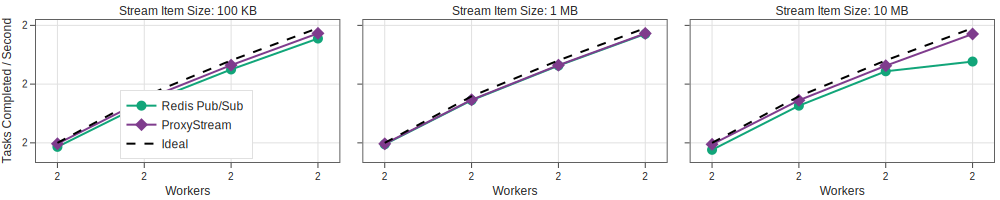

In [6]:
path = '../data/alderaan/1-stream-scaling/'

if not os.path.isdir(path):
    print(f'The directory {path} does not exist.')
else:
    data = load_data(path)

    layout = dict(width=1000, height=200, margin=dict(t=20))

    fig = generate_figure(data, layout)
    fig.show(renderer='svg')

    figure_dir = pathlib.Path('../figures/alderaan/')
    figure_dir.mkdir(exist_ok=True)
    fig.write_image(figure_dir / '1-stream-scaling.pdf')

## Polaris Results

The following block processes the exact data used to produce the figures in our SC24 submission.
You do not need to modify this block, unless you would like to further explore the results of our experimental runs.

shape: (10, 4)
┌─────────────┬─────────────────┬─────────┬───────────────┐
│ use_proxies ┆ data_size_bytes ┆ workers ┆ throughput_gb │
│ ---         ┆ ---             ┆ ---     ┆ ---           │
│ bool        ┆ i64             ┆ i64     ┆ f64           │
╞═════════════╪═════════════════╪═════════╪═══════════════╡
│ false       ┆ 10000           ┆ 2048    ┆ 0.010136      │
│ true        ┆ 10000           ┆ 2048    ┆ 0.008455      │
│ false       ┆ 100000          ┆ 2048    ┆ 0.039972      │
│ true        ┆ 100000          ┆ 2048    ┆ 0.119284      │
│ false       ┆ 1000000         ┆ 2048    ┆ 0.056454      │
│ true        ┆ 1000000         ┆ 2048    ┆ 1.051867      │
│ false       ┆ 10000000        ┆ 256     ┆ 0.058992      │
│ true        ┆ 10000000        ┆ 256     ┆ 1.022308      │
│ false       ┆ 100000000       ┆ 256     ┆ 0.055922      │
│ true        ┆ 100000000       ┆ 256     ┆ 1.219122      │
└─────────────┴─────────────────┴─────────┴───────────────┘


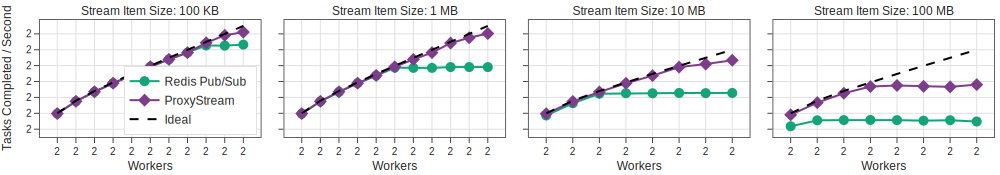

In [7]:
data = load_data('../data/polaris/1-stream-scaling/')

print_throughput(data)

layout = dict(width=1000, height=175, margin=dict(t=20))

fig = generate_figure(data, layout, skip_sizes=[10000])
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '1-stream-scaling.pdf')